# Portfolio Analyzer
A utility that takes a portfolio as an input with the following calculations 
   * analyzes the current P&L
   * compares with S&P 500
   * YTD Return vs SPY YTD 
   * Total Return vs SP500
   * P&L Total Return SPY
   * Total Cumulative Return over time 
   * Daily Returns, Cumulative Return by Ticker
   * Rolling 21 day return 
   * Sharpe Ratio 
   * Rolling 60 day Beta 
   * Simulated Returns
   * Simulated Cumulative P&L
   
The results are displayed in Dash/Plotly


This project was built by Sumeet Vaidya, Pat Beeson, William Alford and Scott Oziros

In [82]:
# Import initial libraries
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#import alpaca_trade_api as tradeapi

import dash
from dash import dcc
from dash import html
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode(connected=True)
import ipywidgets as widgets
import dash_table
import dash_table.FormatTemplate as FormatTemplate
from dash_table.Format import Format, Scheme, Symbol, Group

from pandas_datareader import data as pdr
import yfinance as yf

from MCForecastTools import MCSimulation

## Inputs : 
The Holdings.xlsx file. This is the basis for all calculations


In [83]:
#Read the Holdings file

portfolio_df = pd.read_excel('Holdings.xlsx', sheet_name='Portfolio', parse_dates=True)
portfolio_df.head(10)

,Acquisition Date,Ticker,Quantity,Unit Cost,Cost Basis,Start of Year
0,2019-02-07,AAPL,300,43.50,13050.00,2020-12-31
1,2019-02-07,TSLA,200,70.50,14100.00,2020-12-31
2,2019-02-07,AMZN,50,1716.00,85800.00,2020-12-31
3,2019-02-07,GOOG,50,1109.00,55450.00,2020-12-31
4,2019-02-07,NFLX,75,345.40,25905.00,2020-12-31
5,2019-02-07,WMT,125,149.35,18668.75,2020-12-31
6,2019-02-07,FB,150,165.50,24825.00,2020-12-31
7,2019-02-07,TWTR,225,30.31,6819.75,2020-12-31
8,2019-02-07,HD,100,182.00,18200.00,2020-12-31


## Data Sources for Historical data
Alpaca SDK was phased out in favour of Yahoo! Finance as Alpaca SDK did not support Adjusted Closes.
Adjusted Closes are required when there are corporate actions like stock splits.

In [84]:
#Required for Alpaca
# Load .env environment variables
#from dotenv import load_dotenv
#load_dotenv("api.env")

In [85]:
# Set Alpaca API key and secret
#alpaca_api_key = os.getenv("ALPACA_API_KEY")
#alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
#alpaca = tradeapi.REST(
#    alpaca_api_key,
#    alpaca_secret_key,
#    api_version="v2"
#)

## Data Setup to get Real-time Data

In [86]:
# Setup to get real-time data
# Set the tickers and add SPY
portfolio_tickers =portfolio_df['Ticker'].to_list().copy()
tickers = portfolio_df['Ticker'].to_list()
spy_ticker='^GSPC'
tickers.append(spy_ticker)

# Set timeframe to '1D'
#timeframe = "1D"

# Set start and end datetimes 
#start_date = pd.Timestamp("2019-01-01", tz="America/New_York").isoformat()
#end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

start_date = "2019-01-01"
end_date = "2021-12-31"
#For YTD Calcs
#end_last_year = datetime.date.fromisoformat(portfolio_df['Start of Year'][0].strftime('%Y-%m-%d'))
#end_last_year = datetime.date.fromisoformat(portfolio_df['Start of Year'][0].strftime('%Y-%m-%d'))
end_last_year=datetime.date.fromisoformat(portfolio_df['Start of Year'][0].strftime('%Y-%m-%d'))

# Set limit_rows to 1000 to retreive the maximum amount of rows
#limit_rows = 1000

# Get 1 year's worth of historical data for Tesla and Coca-Cola
# YOUR CODE HERE!
#df_ticker = alpaca.get_barset(
#    tickers,
#    timeframe,
#    start=start_date,
#    end=end_date,
#    limit=limit_rows
#).df

#Alpaca does not have Adj Closes. Switching to Yahoo! Finance
yf.pdr_override()

df_ticker = pdr.get_data_yahoo(tickers, start=start_date , end=end_date)
# Display data
df_ticker

[*********************100%***********************]  10 of 10 completed


Adj Close                                                    \
                  AAPL         AMZN          FB         GOOG          HD   
Date                                                                       
2019-01-02   38.326290  1539.130005  135.679993  1045.849976  161.279068   
2019-01-03   34.508713  1500.280029  131.740005  1016.059998  157.724396   
2019-01-04   35.981865  1575.390015  137.949997  1070.709961  162.410934   
2019-01-07   35.901772  1629.510010  138.050003  1068.390015  165.610107   
2019-01-08   36.586174  1656.579956  142.529999  1076.280029  166.405243   
...                ...          ...         ...          ...         ...   
2021-11-09  150.809998  3576.229980  335.369995  2984.969971  370.649994   
2021-11-10  147.919998  3482.050049  327.640015  2932.520020  368.579987   
2021-11-11  147.869995  3472.500000  327.739990  2934.959961  367.630005   
2021-11-12  149.990005  3525.149902  340.890015  2992.909912  372.630005   
2021-11-15  150.000000  3545.679932  347.559998  2987.760010  371.079987   

                                                                         ...  \
                  NFLX         TSLA       TWTR         WMT        ^GSPC  ...   
Date                                                                     ...   
2019-01-02  267.660004    62.023998  28.809999   88.933060  2510.030029  ...   
2019-01-03  271.200012    60.071999  27.990000   88.475716  2447.889893  ...   
2019-01-04  297.570007    63.537998  29.950001   89.028351  2531.939941  ...   
2019-01-07  315.339996    66.991997  31.340000   90.076385  2549.689941  ...   
2019-01-08  320.269989    67.070000  31.799999   90.705238  2574.409912  ...   
...                ...          ...        ...         ...          ...  ...   
2021-11-09  655.989990  1023.500000  53.700001  149.789993  4685.250000  ...   
2021-11-10  646.909973  1067.949951  52.330002  148.440002  4646.709961  ...   
2021-11-11  657.580017  1063.510010  51.980000  148.500000  4649.270020  ...   
2021-11-12  682.609985  1033.420044  52.250000  147.759995  4682.850098  ...   
2021-11-15  679.330017  1013.390015  52.950001  146.910004  4682.799805  ...   

               Volume                                                 \
                 AAPL     AMZN        FB     GOOG       HD      NFLX   
Date                                                                   
2019-01-02  148158800  7983100  28146200  1532600  4242900  11679500   
2019-01-03  365248800  6975600  22717900  1841100  4810500  14969600   
2019-01-04  234428400  9182600  29002100  2093900  4762600  19330100   
2019-01-07  219111200  7993200  20089300  1981900  4928800  18620100   
2019-01-08  164101200  8881400  26263800  1764900  4722400  15359200   
...               ...      ...       ...      ...      ...       ...   
2021-11-09   56787900  4294900  17556700   843800  2183300   2415600   
2021-11-10   65187100  4027400  21872600  1135400  2161400   2405800   
2021-11-11   41000000  2264400  12376600   623200  2387300   2868300   
2021-11-12   63632600  2688500  25387200   852000  2792600   4192700   
2021-11-15   59077700  2927300  25044143   812367  3647800   2871100   

                                                     
                TSLA      TWTR      WMT       ^GSPC  
Date                                                 
2019-01-02  58293000  15053700  8152700  3733160000  
2019-01-03  34826000  19051700  8277300  3822860000  
2019-01-04  36970500  23412600  8029100  4213410000  
2019-01-07  37756000  19917800  7789700  4104710000  
2019-01-08  35042500  18915200  7200900  4083030000  
...              ...       ...      ...         ...  
2021-11-09  59105800  11230100  5000600  3110230000  
2021-11-10  42802700  18858400  5601200  3581630000  
2021-11-11  22396600  13972100  4534400  2623140000  
2021-11-12  25182300  13283300  6100800  2865790000  
2021-11-15  34690700  21161587  9610000  2618980000  

[725 rows x 60 columns]

In [87]:
df_ticker.dtypes

Adj Close  AAPL     float64
           AMZN     float64
           FB       float64
           GOOG     float64
           HD       float64
           NFLX     float64
           TSLA     float64
           TWTR     float64
           WMT      float64
           ^GSPC    float64
Close      AAPL     float64
           AMZN     float64
           FB       float64
           GOOG     float64
           HD       float64
           NFLX     float64
           TSLA     float64
           TWTR     float64
           WMT      float64
           ^GSPC    float64
High       AAPL     float64
           AMZN     float64
           FB       float64
           GOOG     float64
           HD       float64
           NFLX     float64
           TSLA     float64
           TWTR     float64
           WMT      float64
           ^GSPC    float64
Low        AAPL     float64
           AMZN     float64
           FB       float64
           GOOG     float64
           HD       float64
           NFLX     

In [88]:
#verify the dataframe has correct data
df_ticker.tail()

Adj Close                                                    \
                  AAPL         AMZN          FB         GOOG          HD   
Date                                                                       
2021-11-09  150.809998  3576.229980  335.369995  2984.969971  370.649994   
2021-11-10  147.919998  3482.050049  327.640015  2932.520020  368.579987   
2021-11-11  147.869995  3472.500000  327.739990  2934.959961  367.630005   
2021-11-12  149.990005  3525.149902  340.890015  2992.909912  372.630005   
2021-11-15  150.000000  3545.679932  347.559998  2987.760010  371.079987   

                                                                         ...  \
                  NFLX         TSLA       TWTR         WMT        ^GSPC  ...   
Date                                                                     ...   
2021-11-09  655.989990  1023.500000  53.700001  149.789993  4685.250000  ...   
2021-11-10  646.909973  1067.949951  52.330002  148.440002  4646.709961  ...   
2021-11-11  657.580017  1063.510010  51.980000  148.500000  4649.270020  ...   
2021-11-12  682.609985  1033.420044  52.250000  147.759995  4682.850098  ...   
2021-11-15  679.330017  1013.390015  52.950001  146.910004  4682.799805  ...   

              Volume                                                          \
                AAPL     AMZN        FB     GOOG       HD     NFLX      TSLA   
Date                                                                           
2021-11-09  56787900  4294900  17556700   843800  2183300  2415600  59105800   
2021-11-10  65187100  4027400  21872600  1135400  2161400  2405800  42802700   
2021-11-11  41000000  2264400  12376600   623200  2387300  2868300  22396600   
2021-11-12  63632600  2688500  25387200   852000  2792600  4192700  25182300   
2021-11-15  59077700  2927300  25044143   812367  3647800  2871100  34690700   

                                           
                TWTR      WMT       ^GSPC  
Date                                       
2021-11-09  11230100  5000600  3110230000  
2021-11-10  18858400  5601200  3581630000  
2021-11-11  13972100  4534400  2623140000  
2021-11-12  13283300  6100800  2865790000  
2021-11-15  21161587  9610000  2618980000  

[5 rows x 60 columns]

### Get Closing Prices using the Adj Close from the dataset

In [89]:
# Create and empty DataFrame for closing prices

df_closing_prices = pd.DataFrame()
for ticker in tickers:
    df_closing_prices[ticker]=df_ticker['Adj Close'][ticker]
    
# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date
df_closing_prices.index.name='Date'
df_closing_prices.tail()    

,AAPL,TSLA,AMZN,GOOG,NFLX,WMT,FB,TWTR,HD,^GSPC
Date,,,,,,,,,,
2021-11-09,150.809998,1023.500000,3576.229980,2984.969971,655.989990,149.789993,335.369995,53.700001,370.649994,4685.250000
2021-11-10,147.919998,1067.949951,3482.050049,2932.520020,646.909973,148.440002,327.640015,52.330002,368.579987,4646.709961
2021-11-11,147.869995,1063.510010,3472.500000,2934.959961,657.580017,148.500000,327.739990,51.980000,367.630005,4649.270020
2021-11-12,149.990005,1033.420044,3525.149902,2992.909912,682.609985,147.759995,340.890015,52.250000,372.630005,4682.850098
2021-11-15,150.000000,1013.390015,3545.679932,2987.760010,679.330017,146.910004,347.559998,52.950001,371.079987,4682.799805


In [90]:
#print the dataframe for closing prices
df_closing_prices

,AAPL,TSLA,AMZN,GOOG,NFLX,WMT,FB,TWTR,HD,^GSPC
Date,,,,,,,,,,
2019-01-02,38.326290,62.023998,1539.130005,1045.849976,267.660004,88.933060,135.679993,28.809999,161.279068,2510.030029
2019-01-03,34.508713,60.071999,1500.280029,1016.059998,271.200012,88.475716,131.740005,27.990000,157.724396,2447.889893
2019-01-04,35.981865,63.537998,1575.390015,1070.709961,297.570007,89.028351,137.949997,29.950001,162.410934,2531.939941
2019-01-07,35.901772,66.991997,1629.510010,1068.390015,315.339996,90.076385,138.050003,31.340000,165.610107,2549.689941
2019-01-08,36.586174,67.070000,1656.579956,1076.280029,320.269989,90.705238,142.529999,31.799999,166.405243,2574.409912
...,...,...,...,...,...,...,...,...,...,...
2021-11-09,150.809998,1023.500000,3576.229980,2984.969971,655.989990,149.789993,335.369995,53.700001,370.649994,4685.250000
2021-11-10,147.919998,1067.949951,3482.050049,2932.520020,646.909973,148.440002,327.640015,52.330002,368.579987,4646.709961
2021-11-11,147.869995,1063.510010,3472.500000,2934.959961,657.580017,148.500000,327.739990,51.980000,367.630005,4649.270020


In [91]:
portfolio_df

,Acquisition Date,Ticker,Quantity,Unit Cost,Cost Basis,Start of Year
0,2019-02-07,AAPL,300,43.50,13050.00,2020-12-31
1,2019-02-07,TSLA,200,70.50,14100.00,2020-12-31
2,2019-02-07,AMZN,50,1716.00,85800.00,2020-12-31
3,2019-02-07,GOOG,50,1109.00,55450.00,2020-12-31
4,2019-02-07,NFLX,75,345.40,25905.00,2020-12-31
5,2019-02-07,WMT,125,149.35,18668.75,2020-12-31
6,2019-02-07,FB,150,165.50,24825.00,2020-12-31
7,2019-02-07,TWTR,225,30.31,6819.75,2020-12-31
8,2019-02-07,HD,100,182.00,18200.00,2020-12-31


In [92]:
# Grab the latest stock close price by using the last line in the dataframe

df_close_latest = df_closing_prices.iloc[-1].to_frame('Last Close')
df_close_latest.index.name='Ticker'
df_close_latest

,Last Close
Ticker,
AAPL,150.000000
TSLA,1013.390015
AMZN,3545.679932
GOOG,2987.760010
NFLX,679.330017
WMT,146.910004
FB,347.559998
TWTR,52.950001
HD,371.079987


In [93]:
#get the End of Last year Closing price using the information from the Holdings file.
#the code should be enhanced to use the last date of the prior year
df_close_YTD_start = df_closing_prices.loc[end_last_year].to_frame('YTD Close')
df_close_YTD_start.index.name="Ticker"
df_close_YTD_start

,YTD Close
Ticker,
AAPL,131.877014
TSLA,705.669983
AMZN,3256.929932
GOOG,1751.880005
NFLX,540.729980
WMT,142.464844
FB,273.160004
TWTR,54.150002
HD,261.260590


In [94]:
#Switch the portfolio dataframe to using the Ticker as an index
portfolio_df.set_index(['Ticker'], inplace=True)

portfolio_df.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year
Ticker,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31
TSLA,2019-02-07,200,70.5,14100.0,2020-12-31
AMZN,2019-02-07,50,1716.0,85800.0,2020-12-31
GOOG,2019-02-07,50,1109.0,55450.0,2020-12-31
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31


In [95]:
#Transpose the portfolio df to get info by Ticker
df_T = portfolio_df.T.copy()

In [96]:
#Verify the quantity of one stock
df_T['AAPL']['Quantity']

300

In [97]:
df_portfolio_value = df_closing_prices.copy()
for ticker in portfolio_tickers:
    df_portfolio_value[ticker]=df_portfolio_value[ticker] * df_T[ticker]['Quantity']
    
df_portfolio_value = df_portfolio_value.drop(columns='^GSPC')

In [98]:
# Merge the portfolio dataframe with the  close dataframe; they are being joined by their indexes.

merged_portfolio = pd.merge(portfolio_df, df_close_latest, left_index=True, right_index=True)
merged_portfolio.index.name="Ticker"
merged_portfolio.head(10)

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close
Ticker,,,,,,
AAPL,2019-02-07,300,43.50,13050.00,2020-12-31,150.000000
TSLA,2019-02-07,200,70.50,14100.00,2020-12-31,1013.390015
AMZN,2019-02-07,50,1716.00,85800.00,2020-12-31,3545.679932
GOOG,2019-02-07,50,1109.00,55450.00,2020-12-31,2987.760010
NFLX,2019-02-07,75,345.40,25905.00,2020-12-31,679.330017
WMT,2019-02-07,125,149.35,18668.75,2020-12-31,146.910004
FB,2019-02-07,150,165.50,24825.00,2020-12-31,347.559998
TWTR,2019-02-07,225,30.31,6819.75,2020-12-31,52.950001
HD,2019-02-07,100,182.00,18200.00,2020-12-31,371.079987


In [99]:
# The below creates a new column which is the ticker return; takes the latest adjusted close for each position
# and divides that by the initial share cost.

merged_portfolio['Ticker Return'] = merged_portfolio['Last Close'] / merged_portfolio['Unit Cost'] - 1
merged_portfolio


,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return
Ticker,,,,,,,
AAPL,2019-02-07,300,43.50,13050.00,2020-12-31,150.000000,2.448276
TSLA,2019-02-07,200,70.50,14100.00,2020-12-31,1013.390015,13.374326
AMZN,2019-02-07,50,1716.00,85800.00,2020-12-31,3545.679932,1.066247
GOOG,2019-02-07,50,1109.00,55450.00,2020-12-31,2987.760010,1.694103
NFLX,2019-02-07,75,345.40,25905.00,2020-12-31,679.330017,0.966792
WMT,2019-02-07,125,149.35,18668.75,2020-12-31,146.910004,-0.016337
FB,2019-02-07,150,165.50,24825.00,2020-12-31,347.559998,1.100060
TWTR,2019-02-07,225,30.31,6819.75,2020-12-31,52.950001,0.746948
HD,2019-02-07,100,182.00,18200.00,2020-12-31,371.079987,1.038901


In [100]:
#Get S&P Closes and index by date
df_spy_closing_prices=df_closing_prices['^GSPC'].to_frame('SPY Closes')
df_spy_closing_prices.index = df_spy_closing_prices.index.astype('datetime64[ns]')
df_spy_closing_prices.index.name='Date'
df_spy_closing_prices

,SPY Closes
Date,
2019-01-02,2510.030029
2019-01-03,2447.889893
2019-01-04,2531.939941
2019-01-07,2549.689941
2019-01-08,2574.409912
...,...
2021-11-09,4685.250000
2021-11-10,4646.709961
2021-11-11,4649.270020


### Compute the Current PNL, and compare with S&P 500

In [101]:
# Here we are merging the new dataframe with the sp500 adjusted closes since the sp start price based on 
# each ticker's acquisition date and sp500 close date.

merged_portfolio_sp = pd.merge(merged_portfolio, df_spy_closing_prices, left_on='Acquisition Date', right_index=True)
merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes
Ticker,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,150.000000,2.448276,2706.050049
TSLA,2019-02-07,200,70.5,14100.0,2020-12-31,1013.390015,13.374326,2706.050049
AMZN,2019-02-07,50,1716.0,85800.0,2020-12-31,3545.679932,1.066247,2706.050049
GOOG,2019-02-07,50,1109.0,55450.0,2020-12-31,2987.760010,1.694103,2706.050049
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,679.330017,0.966792,2706.050049


In [102]:
# This new column determines what SP 500 equivalent purchase would have been at purchase date of stock.
merged_portfolio_sp['Equiv SPY Shares'] = merged_portfolio_sp['Cost Basis'] / merged_portfolio_sp['SPY Closes']
merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares
Ticker,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,150.000000,2.448276,2706.050049,4.822527
TSLA,2019-02-07,200,70.5,14100.0,2020-12-31,1013.390015,13.374326,2706.050049,5.210547
AMZN,2019-02-07,50,1716.0,85800.0,2020-12-31,3545.679932,1.066247,2706.050049,31.706731
GOOG,2019-02-07,50,1109.0,55450.0,2020-12-31,2987.760010,1.694103,2706.050049,20.491121
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,679.330017,0.966792,2706.050049,9.572994


In [24]:
df_close_latest.loc['^GSPC']

Last Close    4682.799805
Name: ^GSPC, dtype: float64

In [25]:
df_closing_prices.iloc[-1]['^GSPC']

4682.7998046875

In [26]:
# We are joining the developing dataframe with the sp500 closes again, this time with the latest close for SP.
merged_portfolio_sp['SPY Latest Close'] =  df_closing_prices.iloc[-1]['^GSPC']

merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close
Ticker,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,150.000000,2.448276,2706.050049,4.822527,4682.799805
TSLA,2019-02-07,200,70.5,14100.0,2020-12-31,1013.390015,13.374326,2706.050049,5.210547,4682.799805
AMZN,2019-02-07,50,1716.0,85800.0,2020-12-31,3545.679932,1.066247,2706.050049,31.706731,4682.799805
GOOG,2019-02-07,50,1109.0,55450.0,2020-12-31,2987.760010,1.694103,2706.050049,20.491121,4682.799805
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,679.330017,0.966792,2706.050049,9.572994,4682.799805


In [27]:
# Percent return of SP from acquisition date of position through latest trading day.
merged_portfolio_sp['SP Return'] = merged_portfolio_sp['SPY Latest Close'] / merged_portfolio_sp['SPY Closes'] - 1

# This is a new column which takes the tickers return and subtracts the sp 500 equivalent range return.
merged_portfolio_sp['Abs. Return Compare'] = merged_portfolio_sp['Ticker Return'] - merged_portfolio_sp['SP Return']

# This is a new column where we calculate the ticker's share value by multiplying the original quantity by the latest close.
merged_portfolio_sp['Ticker Share Value'] = merged_portfolio_sp['Quantity'] * merged_portfolio_sp['Last Close']

# We calculate the equivalent SP 500 Value if we take the original SP shares * the latest SP 500 share price.
merged_portfolio_sp['SPY Value'] = merged_portfolio_sp['Equiv SPY Shares'] * merged_portfolio_sp['SPY Latest Close']

# This is a new column where we take the current market value for the shares and subtract the SP 500 value.
merged_portfolio_sp['Abs Value Compare'] = merged_portfolio_sp['Ticker Share Value'] - merged_portfolio_sp['SPY Value']

# This column calculates profit / loss for stock position.
merged_portfolio_sp['Stock Gain / (Loss)'] = merged_portfolio_sp['Ticker Share Value'] - merged_portfolio_sp['Cost Basis']

# This column calculates profit / loss for SP 500.
merged_portfolio_sp['SPY Gain / (Loss)'] = merged_portfolio_sp['SPY Value'] - merged_portfolio_sp['Cost Basis']

merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,SP Return,Abs. Return Compare,Ticker Share Value,SPY Value,Abs Value Compare,Stock Gain / (Loss),SPY Gain / (Loss)
Ticker,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,150.000000,2.448276,2706.050049,4.822527,4682.799805,0.730493,1.717783,45000.000000,22582.929491,22417.070509,31950.000000,9532.929491
TSLA,2019-02-07,200,70.5,14100.0,2020-12-31,1013.390015,13.374326,2706.050049,5.210547,4682.799805,0.730493,12.643834,202678.002930,24399.946806,178278.056124,188578.002930,10299.946806
AMZN,2019-02-07,50,1716.0,85800.0,2020-12-31,3545.679932,1.066247,2706.050049,31.706731,4682.799805,0.730493,0.335754,177283.996582,148476.272054,28807.724528,91483.996582,62676.272054
GOOG,2019-02-07,50,1109.0,55450.0,2020-12-31,2987.760010,1.694103,2706.050049,20.491121,4682.799805,0.730493,0.963610,149388.000488,95955.819177,53432.181311,93938.000488,40505.819177
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,679.330017,0.966792,2706.050049,9.572994,4682.799805,0.730493,0.236299,50949.751282,44828.412909,6121.338373,25044.751282,18923.412909


In [28]:
# Merge the overall dataframe with the adj close start of year dataframe for YTD tracking of tickers.
# Should not need to do the outer join;

merged_portfolio_sp_YTD = pd.merge(merged_portfolio_sp, df_close_YTD_start, left_index=True, right_index=True)
# , how='outer'
#merged_portfolio_sp_YTD.rename(columns={'2020-12-31 00:00:00-05:00':'SPY YTD Start Close'}, inplace=True)
merged_portfolio_sp_YTD.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,SP Return,Abs. Return Compare,Ticker Share Value,SPY Value,Abs Value Compare,Stock Gain / (Loss),SPY Gain / (Loss),YTD Close
Ticker,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,150.000000,2.448276,2706.050049,4.822527,4682.799805,0.730493,1.717783,45000.000000,22582.929491,22417.070509,31950.000000,9532.929491,131.876999
TSLA,2019-02-07,200,70.5,14100.0,2020-12-31,1013.390015,13.374326,2706.050049,5.210547,4682.799805,0.730493,12.643834,202678.002930,24399.946806,178278.056124,188578.002930,10299.946806,705.669983
AMZN,2019-02-07,50,1716.0,85800.0,2020-12-31,3545.679932,1.066247,2706.050049,31.706731,4682.799805,0.730493,0.335754,177283.996582,148476.272054,28807.724528,91483.996582,62676.272054,3256.929932
GOOG,2019-02-07,50,1109.0,55450.0,2020-12-31,2987.760010,1.694103,2706.050049,20.491121,4682.799805,0.730493,0.963610,149388.000488,95955.819177,53432.181311,93938.000488,40505.819177,1751.880005
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,679.330017,0.966792,2706.050049,9.572994,4682.799805,0.730493,0.236299,50949.751282,44828.412909,6121.338373,25044.751282,18923.412909,540.729980


In [29]:
merged_portfolio_sp_YTD.dtypes

Acquisition Date       datetime64[ns]
Quantity                        int64
Unit Cost                     float64
Cost Basis                    float64
Start of Year          datetime64[ns]
Last Close                    float64
Ticker Return                 float64
SPY Closes                    float64
Equiv SPY Shares              float64
SPY Latest Close              float64
SP Return                     float64
Abs. Return Compare           float64
Ticker Share Value            float64
SPY Value                     float64
Abs Value Compare             float64
Stock Gain / (Loss)           float64
SPY Gain / (Loss)             float64
YTD Close                     float64
dtype: object

#### Compute YTD Statistics

In [30]:
# We are joining the developing dataframe with the sp500 closes again, this time with the latest close for SP.
merged_portfolio_sp_YTD['SPY YTD Close'] =  df_closing_prices.loc[end_last_year]['^GSPC']

merged_portfolio_sp_YTD.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,SP Return,Abs. Return Compare,Ticker Share Value,SPY Value,Abs Value Compare,Stock Gain / (Loss),SPY Gain / (Loss),YTD Close,SPY YTD Close
Ticker,,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,150.000000,2.448276,2706.050049,4.822527,4682.799805,0.730493,1.717783,45000.000000,22582.929491,22417.070509,31950.000000,9532.929491,131.876999,3756.070068
TSLA,2019-02-07,200,70.5,14100.0,2020-12-31,1013.390015,13.374326,2706.050049,5.210547,4682.799805,0.730493,12.643834,202678.002930,24399.946806,178278.056124,188578.002930,10299.946806,705.669983,3756.070068
AMZN,2019-02-07,50,1716.0,85800.0,2020-12-31,3545.679932,1.066247,2706.050049,31.706731,4682.799805,0.730493,0.335754,177283.996582,148476.272054,28807.724528,91483.996582,62676.272054,3256.929932,3756.070068
GOOG,2019-02-07,50,1109.0,55450.0,2020-12-31,2987.760010,1.694103,2706.050049,20.491121,4682.799805,0.730493,0.963610,149388.000488,95955.819177,53432.181311,93938.000488,40505.819177,1751.880005,3756.070068
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,679.330017,0.966792,2706.050049,9.572994,4682.799805,0.730493,0.236299,50949.751282,44828.412909,6121.338373,25044.751282,18923.412909,540.729980,3756.070068


In [31]:
merged_portfolio_sp_YTD.dtypes

Acquisition Date       datetime64[ns]
Quantity                        int64
Unit Cost                     float64
Cost Basis                    float64
Start of Year          datetime64[ns]
Last Close                    float64
Ticker Return                 float64
SPY Closes                    float64
Equiv SPY Shares              float64
SPY Latest Close              float64
SP Return                     float64
Abs. Return Compare           float64
Ticker Share Value            float64
SPY Value                     float64
Abs Value Compare             float64
Stock Gain / (Loss)           float64
SPY Gain / (Loss)             float64
YTD Close                     float64
SPY YTD Close                 float64
dtype: object

In [32]:
# YTD return for portfolio position.
merged_portfolio_sp_YTD['Share YTD'] = merged_portfolio_sp_YTD['Last Close'] / merged_portfolio_sp_YTD['YTD Close'] - 1

# YTD return for SP to run compares.
merged_portfolio_sp_YTD['SPY YTD'] = merged_portfolio_sp_YTD['SPY Latest Close'] / merged_portfolio_sp_YTD['SPY YTD Close'] - 1



In [33]:
# Cumulative sum of original investment
merged_portfolio_sp_YTD['Cum Invst'] = merged_portfolio_sp_YTD['Cost Basis'].cumsum()

# Cumulative sum of Ticker Share Value (latest FMV based on initial quantity purchased).
merged_portfolio_sp_YTD['Cum Ticker Returns'] = merged_portfolio_sp_YTD['Ticker Share Value'].cumsum()

# Cumulative sum of SP Share Value (latest FMV driven off of initial SP equiv purchase).
merged_portfolio_sp_YTD['Cum SP Returns'] = merged_portfolio_sp_YTD['SPY Value'].cumsum()

# Cumulative CoC multiple return for stock investments
merged_portfolio_sp_YTD['Cum Ticker ROI Mult'] = merged_portfolio_sp_YTD['Cum Ticker Returns'] / merged_portfolio_sp_YTD['Cum Invst']

merged_portfolio_sp_YTD.head()


,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,...,Stock Gain / (Loss),SPY Gain / (Loss),YTD Close,SPY YTD Close,Share YTD,SPY YTD,Cum Invst,Cum Ticker Returns,Cum SP Returns,Cum Ticker ROI Mult
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,150.000000,2.448276,2706.050049,4.822527,4682.799805,...,31950.000000,9532.929491,131.876999,3756.070068,0.137424,0.246729,13050.0,45000.000000,22582.929491,3.448276
TSLA,2019-02-07,200,70.5,14100.0,2020-12-31,1013.390015,13.374326,2706.050049,5.210547,4682.799805,...,188578.002930,10299.946806,705.669983,3756.070068,0.436068,0.246729,27150.0,247678.002930,46982.876297,9.122578
AMZN,2019-02-07,50,1716.0,85800.0,2020-12-31,3545.679932,1.066247,2706.050049,31.706731,4682.799805,...,91483.996582,62676.272054,3256.929932,3756.070068,0.088657,0.246729,112950.0,424961.999512,195459.148351,3.762390
GOOG,2019-02-07,50,1109.0,55450.0,2020-12-31,2987.760010,1.694103,2706.050049,20.491121,4682.799805,...,93938.000488,40505.819177,1751.880005,3756.070068,0.705459,0.246729,168400.0,574350.000000,291414.967528,3.410629
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,679.330017,0.966792,2706.050049,9.572994,4682.799805,...,25044.751282,18923.412909,540.729980,3756.070068,0.256320,0.246729,194305.0,625299.751282,336243.380437,3.218135


In [34]:
merged_portfolio_sp_YTD['Current Value'] = merged_portfolio_sp_YTD['Last Close'] * merged_portfolio_sp_YTD['Quantity']
merged_portfolio_sp_YTD['Pct Change'] = merged_portfolio_sp_YTD['Current Value'] / merged_portfolio_sp_YTD['Cost Basis']

# Calculate Daily Returns

In [35]:
#Daily Returns
df_daily_returns = pd.DataFrame()
for ticker in portfolio_tickers:
    df_daily_returns[ticker] = df_closing_prices[ticker].pct_change()
    
df_daily_returns.head()


,AAPL,TSLA,AMZN,GOOG,NFLX,WMT,FB,TWTR,HD
Date,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.099607,-0.031472,-0.025242,-0.028484,0.013226,-0.005142,-0.029039,-0.028462,-0.022041
2019-01-04,0.042689,0.057697,0.050064,0.053786,0.097234,0.006246,0.047138,0.070025,0.029714
2019-01-07,-0.002226,0.054361,0.034353,-0.002167,0.059717,0.011772,0.000725,0.046411,0.019698
2019-01-08,0.019063,0.001164,0.016612,0.007385,0.015634,0.006981,0.032452,0.014678,0.004801


# Calculate Cumulative Daily Returns

In [36]:
# Calculate and plot the cumulative returns of the 4 fund portfolios 
cum_daily_returns_df = (1 + df_daily_returns).cumprod() - 1
cum_daily_returns_df.dropna(inplace=True)
cum_daily_returns_df.head()

,AAPL,TSLA,AMZN,GOOG,NFLX,WMT,FB,TWTR,HD
Date,,,,,,,,,
2019-01-03,-0.099607,-0.031472,-0.025242,-0.028484,0.013226,-0.005142,-0.029039,-0.028462,-0.022041
2019-01-04,-0.061170,0.024410,0.023559,0.023770,0.111746,0.001072,0.016731,0.039570,0.007018
2019-01-07,-0.063260,0.080098,0.058721,0.021552,0.178136,0.012856,0.017468,0.087817,0.026855
2019-01-08,-0.045403,0.081356,0.076309,0.029096,0.196555,0.019927,0.050486,0.103783,0.031785
2019-01-09,-0.029192,0.091610,0.078155,0.027547,0.195397,0.016606,0.063016,0.119403,0.042457


<AxesSubplot:title={'center':'Cumulative Daily Return of the Portfolio'}>

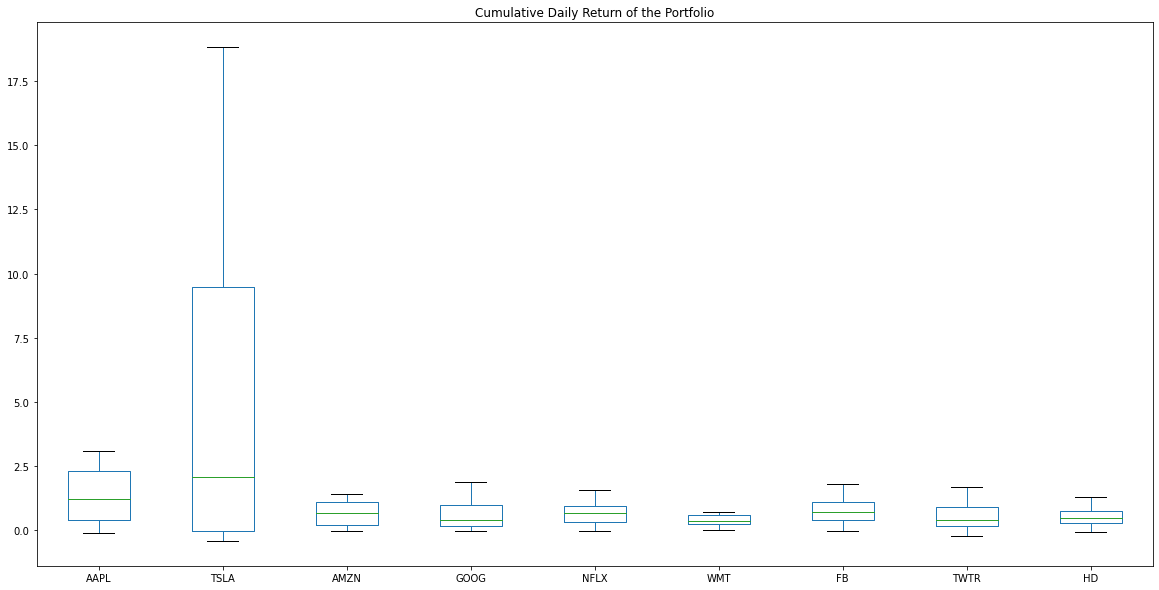

In [37]:
cum_daily_returns_df.plot(figsize=(20,10),kind='box' ,title="Cumulative Daily Return of the Portfolio")

# Standard Deviation

In [38]:
df_daily_returns_dev= df_daily_returns.std()
df_daily_returns_dev.sort_values(ascending=True)
df_daily_returns_dev

AAPL    0.021624
TSLA    0.042473
AMZN    0.018618
GOOG    0.018787
NFLX    0.024307
WMT     0.014016
FB      0.022374
TWTR    0.031868
HD      0.018735
dtype: float64

## Annualized Standard Deviation

In [39]:
# Calculate and sort the annualized standard deviation (252 trading days) of the portfolio
# Review the annual standard deviations smallest to largest
df_daily_returns_dev_252 = df_daily_returns_dev*np.sqrt(252)
df_daily_returns_dev_252.sort_values(ascending=True)

WMT     0.222493
AMZN    0.295548
HD      0.297402
GOOG    0.298231
AAPL    0.343265
FB      0.355169
NFLX    0.385856
TWTR    0.505886
TSLA    0.674233
dtype: float64

## Rolling 21 Day Daily Return of the Portfolio

<AxesSubplot:title={'center':'Rolling 21 Day Daily Return of the Portfolio'}, xlabel='Date'>

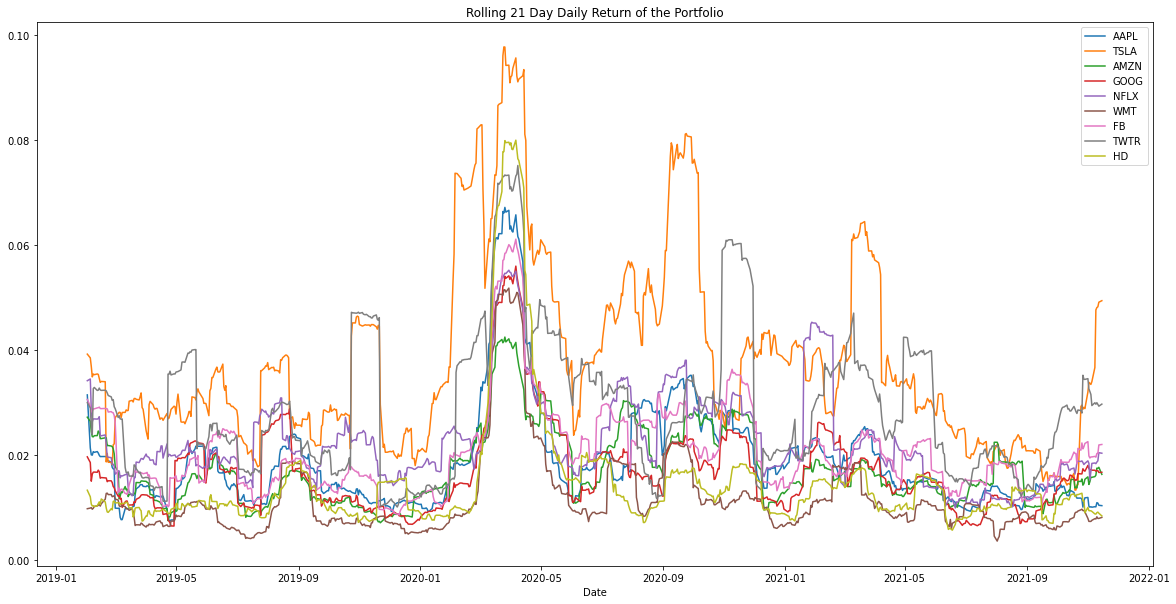

In [40]:
df_daily_returns_std_21=df_daily_returns.rolling(window=21).std()
df_daily_returns_std_21.dropna(inplace=True)
df_daily_returns_std_21.plot(figsize=(20,10),title="Rolling 21 Day Daily Return of the Portfolio")

## Annualized Daily returns

In [41]:
# Calculate the annualized Returns
df_annual_returns=df_daily_returns.mean()*252
df_annual_returns.sort_values(ascending=True)

WMT     0.199245
AMZN    0.334197
HD      0.335373
TWTR    0.342598
FB      0.390663
NFLX    0.398340
GOOG    0.410038
AAPL    0.534342
TSLA    1.200768
dtype: float64

## Sharpe Ratio : 
The Sharpe Ratio is a financial metric often used by investors when assessing the performance of investment management products and professionals. It consists of taking the excess return of the portfolio, relative to the risk-free rate, and dividing it by the standard deviation of the portfolio's excess returns. Conceptually, what this provides is a measurement of the portfolio's outperformance per unit of the portfolio's volatility. All else being equal, portfolios with higher excess returns or lower volatility will show higher Sharpe Ratios, and vice-versa.
<br/>
Usually, any Sharpe ratio greater than 1.0 is considered acceptable to good by investors. A ratio higher than 2.0 is rated as very good. A ratio of 3.0 or higher is considered excellent. A ratio under 1.0 is considered sub-optimal.


In [42]:
# Calculate the annualized Sharpe Ratios for each of the portfolio
# Review the Sharpe ratios sorted lowest to highest
df_sharpe=df_annual_returns/df_daily_returns_dev_252
df_sharpe.sort_values(ascending=True)

TWTR    0.677224
WMT     0.895513
NFLX    1.032354
FB      1.099935
HD      1.127674
AMZN    1.130771
GOOG    1.374901
AAPL    1.556646
TSLA    1.780938
dtype: float64

<AxesSubplot:title={'center':'Sharpe ratios for the portfolio'}>

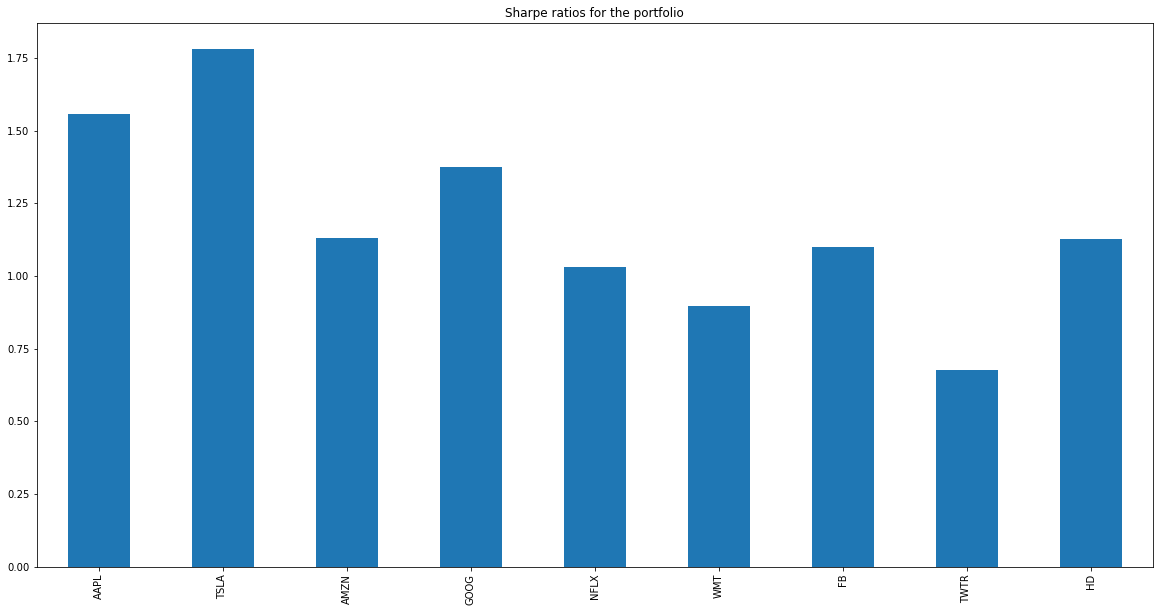

In [43]:
# Visualize the Sharpe ratios as a bar chart
df_sharpe.plot(kind='bar', figsize=(20,10), title='Sharpe ratios for the portfolio')

# Covariance Calculation
If a portfolio has multiple assets, its volatility is calculated using a matrix. A variance-covariance matrix is computed for all the assets. The vector of the weights of the assets in the portfolio is multiplied by the transpose of the vector of the weights of the assets multiplied by the covariance matrix of all of the assets.



In [44]:
# Calculate the variance of the SPY using a rolling 60-day window.
df_spy_daily_returns = df_closing_prices['^GSPC'].pct_change()
df_spy_var=df_spy_daily_returns.rolling(window=60).var()
df_spy_var

Date
2019-01-02         NaN
2019-01-03         NaN
2019-01-04         NaN
2019-01-07         NaN
2019-01-08         NaN
                ...   
2021-11-09    0.000052
2021-11-10    0.000052
2021-11-11    0.000050
2021-11-12    0.000051
2021-11-15    0.000050
Name: ^GSPC, Length: 725, dtype: float64

In [45]:
#Calculate Rolling Covariance 60 day

rolling_covariance_60day = df_daily_returns.rolling(window=60).cov(df_spy_daily_returns)

rolling_covariance_60day.tail()

# get the weights of the stocks in the portfolio using CostBasis
weight_df = portfolio_df
for ticker in portfolio_tickers:
    weight_df = portfolio_df['Cost Basis']/portfolio_df['Cost Basis'].sum()

rolling_covariance_portfolio_60day = rolling_covariance_60day.dot(weight_df.to_list())

rolling_covariance_portfolio_60day

Date
2019-01-02         NaN
2019-01-03         NaN
2019-01-04         NaN
2019-01-07         NaN
2019-01-08         NaN
                ...   
2021-11-09    0.000056
2021-11-10    0.000057
2021-11-11    0.000055
2021-11-12    0.000057
2021-11-15    0.000056
Length: 725, dtype: float64

### Beta Calculation
Beta is a measure of a stock's volatility in relation to the overall market. ... If a stock moves less than the market, the stock's beta is less than 1.0. High-beta stocks are supposed to be riskier but provide higher return potential; low-beta stocks pose less risk but also lower returns.

#### Portfolio Beta
The beta of a portfolio is the weighted sum of the individual asset betas, According to the proportions of the investments in the portfolio. E.g., if 50% of the money is in stock A with a beta of 2.00, and 50% of the money is in stock B with a beta of 1.00,the portfolio beta is 1.50.


In [46]:
# Calculate the beta based on the 60-day rolling covariance compared to the market (S&P 500)
# Review the last five rows of the beta information
rolling_portfolio_beta=rolling_covariance_portfolio_60day/df_spy_var
rolling_portfolio_beta.tail()

Date
2021-11-09    1.089431
2021-11-10    1.091472
2021-11-11    1.112914
2021-11-12    1.129504
2021-11-15    1.132327
dtype: float64

In [47]:
# Calculate the average of the 60-day rolling beta
avg_rolling_portfolio_beta = rolling_portfolio_beta.mean()
avg_rolling_portfolio_beta

1.0929808169933273

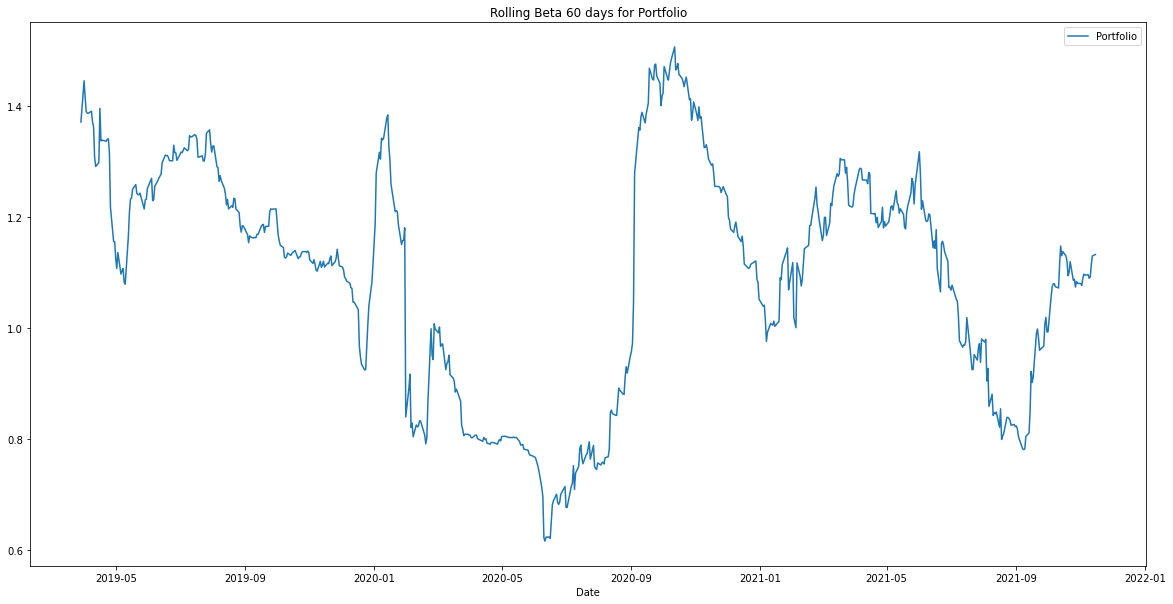

In [48]:
# Plot the rolling beta 
# Include a title parameter and adjust the figure size
ax = rolling_portfolio_beta.plot(figsize=(20,10), title='Rolling Beta 60 days for Portfolio')
ax.legend(["Portfolio"])

In [49]:
df_ticker.head()

Adj Close                                                    \
                 AAPL         AMZN          FB         GOOG          HD   
Date                                                                      
2019-01-02  38.326298  1539.130005  135.679993  1045.849976  161.279037   
2019-01-03  34.508717  1500.280029  131.740005  1016.059998  157.724365   
2019-01-04  35.981861  1575.390015  137.949997  1070.709961  162.410919   
2019-01-07  35.901779  1629.510010  138.050003  1068.390015  165.610107   
2019-01-08  36.586170  1656.579956  142.529999  1076.280029  166.405258   

                                                                      ...  \
                  NFLX       TSLA       TWTR        WMT        ^GSPC  ...   
Date                                                                  ...   
2019-01-02  267.660004  62.023998  28.809999  88.933044  2510.030029  ...   
2019-01-03  271.200012  60.071999  27.990000  88.475723  2447.889893  ...   
2019-01-04  297.570007  63.537998  29.950001  89.028343  2531.939941  ...   
2019-01-07  315.339996  66.991997  31.340000  90.076385  2549.689941  ...   
2019-01-08  320.269989  67.070000  31.799999  90.705223  2574.409912  ...   

               Volume                                                 \
                 AAPL     AMZN        FB     GOOG       HD      NFLX   
Date                                                                   
2019-01-02  148158800  7983100  28146200  1532600  4242900  11679500   
2019-01-03  365248800  6975600  22717900  1841100  4810500  14969600   
2019-01-04  234428400  9182600  29002100  2093900  4762600  19330100   
2019-01-07  219111200  7993200  20089300  1981900  4928800  18620100   
2019-01-08  164101200  8881400  26263800  1764900  4722400  15359200   

                                                     
                TSLA      TWTR      WMT       ^GSPC  
Date                                                 
2019-01-02  58293000  15053700  8152700  3733160000  
2019-01-03  34826000  19051700  8277300  3822860000  
2019-01-04  36970500  23412600  8029100  4213410000  
2019-01-07  37756000  19917800  7789700  4104710000  
2019-01-08  35042500  18915200  7200900  4083030000  

[5 rows x 60 columns]

In [50]:
# Get the Portfolio without the S&P 500 numbers
df_portfolio_ticker = df_ticker
df_portfolio_ticker.columns = df_portfolio_ticker.columns.swaplevel(0, 1)
df_portfolio_ticker.sort_index(axis=1, level=0, inplace=True)
df_portfolio_ticker = df_portfolio_ticker.drop(columns='^GSPC')
df_portfolio_ticker = df_portfolio_ticker.rename(columns={'Adj Close':'close'})


In [51]:
#verify the sum of the weights
weight_df.sum()

1.0

### MonteCarlo Simulation
* The Monte Carlo method uses a random sampling of information to solve a statistical problem; while a simulation is a way to virtually demonstrate a strategy.
* Combined, the Monte Carlo simulation enables a user to come up with a bevy of results for a statistical problem with numerous data points sampled repeatedly.
* The Monte Carlo simulation can be used in corporate finance, options pricing, and especially portfolio management and personal finance planning. 
* On the downside, the simulation is limited in that it can't account for bear markets, recessions, or any other kind of financial crisis that might impact potential results.

In [52]:
# Set number of simulations
num_sims = 1000

# Configure a Monte Carlo simulation to forecast three years daily returns
MC_Portfolio = MCSimulation(
    portfolio_data = df_portfolio_ticker,
    #weights=[0.20, 0.20, 0.40, 0.20],
    weights=weight_df.to_list(),
    num_simulation = num_sims,
    num_trading_days = 252*3
)

In [53]:
#Run the Simulation
MC_Portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007514,1.006540,1.012137,1.000840,1.023512,1.005688,0.998516,0.999553,1.004455,1.004549,...,1.002312,1.015638,1.021347,1.006635,0.987913,0.980699,1.000721,0.995700,1.010320,0.997239
2,1.004069,0.994940,1.016954,0.992393,1.024716,1.012604,0.982364,1.000360,1.010479,0.994941,...,1.012406,1.012480,1.034953,1.002739,0.984268,0.979058,1.004749,1.008583,1.007210,0.987337
3,1.005342,0.994030,1.012505,0.992123,1.032488,1.003070,0.984058,1.005903,1.013683,1.002154,...,1.007606,1.003317,1.046681,1.010009,0.993099,0.973094,1.022531,1.020676,0.995253,0.984899
4,1.027389,0.998336,1.005263,0.984895,1.038866,1.008017,0.976248,1.001039,1.018503,0.995278,...,1.006147,1.000424,1.048102,1.015564,1.004107,0.977925,1.014584,1.019610,0.984787,0.977095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2.868138,3.359222,3.615072,2.632525,6.151230,3.943899,2.270297,2.575317,3.224819,1.969534,...,6.215596,6.014206,4.318465,3.925344,1.884845,5.427353,3.472318,3.134496,6.371036,3.329384
753,2.913385,3.334599,3.587845,2.670319,6.270692,3.942088,2.281385,2.565564,3.223364,1.971320,...,6.218360,6.017831,4.316995,3.965886,1.903494,5.442795,3.492077,3.164164,6.371924,3.330879
754,2.932353,3.333503,3.581013,2.659790,6.232612,3.889476,2.288230,2.568178,3.227173,1.966126,...,6.309006,5.991647,4.270131,4.000731,1.893524,5.397155,3.500928,3.224785,6.395809,3.404147
755,2.961839,3.320412,3.594045,2.647229,6.328280,3.878485,2.288424,2.571124,3.251776,1.965216,...,6.325386,5.923222,4.247489,4.029293,1.867572,5.446771,3.509042,3.206980,6.351067,3.439100


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 756 Trading Days.'}>

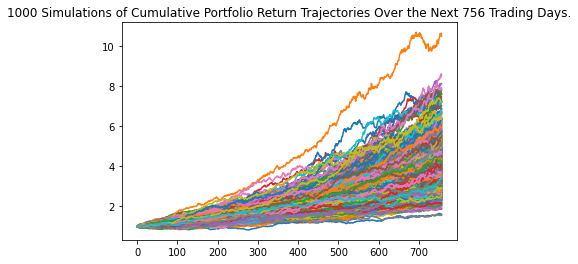

In [103]:
MC_Portfolio.plot_simulation()

In [104]:
#Compute the Simulated Returns
simulated_returns_data = {
    "mean": list(MC_Portfolio.simulated_return.mean(axis=1)),
    "median": list(MC_Portfolio.simulated_return.median(axis=1)),
    "min": list(MC_Portfolio.simulated_return.min(axis=1)),
    "max": list(MC_Portfolio.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
df_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.002210,1.002002,0.973796,1.034794
2,1.004043,1.003972,0.965931,1.043032
3,1.006133,1.006251,0.947291,1.059264
4,1.008404,1.007815,0.944030,1.075937


In [105]:
#Display the Simulated Returns
df_simulated_data=MC_Portfolio.simulated_return
df_simulated_data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007514,1.006540,1.012137,1.000840,1.023512,1.005688,0.998516,0.999553,1.004455,1.004549,...,1.002312,1.015638,1.021347,1.006635,0.987913,0.980699,1.000721,0.995700,1.010320,0.997239
2,1.004069,0.994940,1.016954,0.992393,1.024716,1.012604,0.982364,1.000360,1.010479,0.994941,...,1.012406,1.012480,1.034953,1.002739,0.984268,0.979058,1.004749,1.008583,1.007210,0.987337
3,1.005342,0.994030,1.012505,0.992123,1.032488,1.003070,0.984058,1.005903,1.013683,1.002154,...,1.007606,1.003317,1.046681,1.010009,0.993099,0.973094,1.022531,1.020676,0.995253,0.984899
4,1.027389,0.998336,1.005263,0.984895,1.038866,1.008017,0.976248,1.001039,1.018503,0.995278,...,1.006147,1.000424,1.048102,1.015564,1.004107,0.977925,1.014584,1.019610,0.984787,0.977095


#### Compute the Cumulative P&L

In [106]:
# Set initial investment to the Current Value
initial_investment = merged_portfolio_sp_YTD['Current Value'].sum()

# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl = initial_investment * df_simulated_returns

# Display sample data
cumulative_pnl.head()

,mean,median,min,max
0,744819.250202,744819.250202,744819.250202,744819.250202
1,746465.059913,746310.422490,725301.690017,770734.748721
2,747830.921729,747777.984892,719443.720702,776870.462126
3,749387.186092,749475.372841,705560.557629,788960.307944
4,751078.592845,750639.925259,703131.594012,801378.893588


<AxesSubplot:title={'center':'Simulated Outcomes Behavior of the Portfolio Over the Next 3 Years'}>

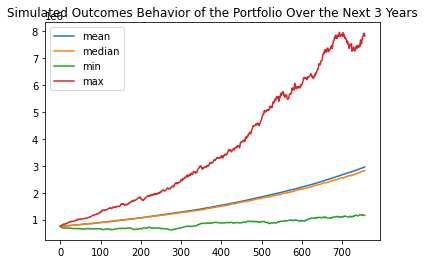

In [107]:
# Plot the Cumulative P&L
cumulative_pnl.plot(title="Simulated Outcomes Behavior of the Portfolio Over the Next 3 Years")

In [108]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_Portfolio.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           1000.000000
mean               3.970140
std                1.133373
min                1.552512
25%                3.166511
50%                3.784786
75%                4.598722
max               10.507729
95% CI Lower       2.293712
95% CI Upper       6.712678
Name: 756, dtype: float64


In [109]:
# Compute the upper bound and lower bound with 95% confidence
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)
print(f"There is a 95% chance that a current investment of ${initial_investment:,.2f} in the portfolio"
      f" over the next year will end within in the range of"
      f" ${ci_lower:,.2f} and ${ci_upper:,.2f}.")

There is a 95% chance that a current investment of $744,819.25 in the portfolio over the next year will end within in the range of $1,708,400.52 and $4,999,732.03.


In [110]:
#display the merged portfolio
merged_portfolio_sp_YTD

,Ticker,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,...,YTD Close,SPY YTD Close,Share YTD,SPY YTD,Cum Invst,Cum Ticker Returns,Cum SP Returns,Cum Ticker ROI Mult,Current Value,Pct Change
0,AAPL,2019-02-07,300,43.50,13050.00,2020-12-31,150.000000,2.448276,2706.050049,4.822527,...,131.876999,3756.070068,0.137424,0.246729,13050.00,45000.000000,22582.929491,3.448276,45000.000000,3.448276
1,TSLA,2019-02-07,200,70.50,14100.00,2020-12-31,1013.390015,13.374326,2706.050049,5.210547,...,705.669983,3756.070068,0.436068,0.246729,27150.00,247678.002930,46982.876297,9.122578,202678.002930,14.374326
2,AMZN,2019-02-07,50,1716.00,85800.00,2020-12-31,3545.679932,1.066247,2706.050049,31.706731,...,3256.929932,3756.070068,0.088657,0.246729,112950.00,424961.999512,195459.148351,3.762390,177283.996582,2.066247
3,GOOG,2019-02-07,50,1109.00,55450.00,2020-12-31,2987.760010,1.694103,2706.050049,20.491121,...,1751.880005,3756.070068,0.705459,0.246729,168400.00,574350.000000,291414.967528,3.410629,149388.000488,2.694103
4,NFLX,2019-02-07,75,345.40,25905.00,2020-12-31,679.330017,0.966792,2706.050049,9.572994,...,540.729980,3756.070068,0.256320,0.246729,194305.00,625299.751282,336243.380437,3.218135,50949.751282,1.966792
5,WMT,2019-02-07,125,149.35,18668.75,2020-12-31,146.910004,-0.016337,2706.050049,6.898893,...,142.464844,3756.070068,0.031202,0.246729,212973.75,643663.501740,368549.515681,3.022267,18363.750458,0.983663
6,FB,2019-02-07,150,165.50,24825.00,2020-12-31,347.559998,1.100060,2706.050049,9.173888,...,273.160004,3756.070068,0.272368,0.246729,237798.75,695797.501373,411508.996494,2.925993,52133.999634,2.100060
7,TWTR,2019-02-07,225,30.31,6819.75,2020-12-31,52.950001,0.746948,2706.050049,2.520186,...,54.150002,3756.070068,-0.022161,0.246729,244618.50,707711.251545,423310.523957,2.893122,11913.750172,1.746948
8,HD,2019-02-07,100,182.00,18200.00,2020-12-31,371.079987,1.038901,2706.050049,6.725670,...,261.260620,3756.070068,0.420344,0.246729,262818.50,744819.250202,454805.490756,2.833968,37107.998657,2.038901


#### Prep work to Display the Charts and Tables

In [111]:
merged_portfolio_sp_YTD.reset_index(inplace=True)

In [112]:
merged_portfolio_sp_YTD.dtypes

index                           int64
Ticker                         object
Acquisition Date       datetime64[ns]
Quantity                        int64
Unit Cost                     float64
Cost Basis                    float64
Start of Year          datetime64[ns]
Last Close                    float64
Ticker Return                 float64
SPY Closes                    float64
Equiv SPY Shares              float64
SPY Latest Close              float64
SP Return                     float64
Abs. Return Compare           float64
Ticker Share Value            float64
SPY Value                     float64
Abs Value Compare             float64
Stock Gain / (Loss)           float64
SPY Gain / (Loss)             float64
YTD Close                     float64
SPY YTD Close                 float64
Share YTD                     float64
SPY YTD                       float64
Cum Invst                     float64
Cum Ticker Returns            float64
Cum SP Returns                float64
Cum Ticker R

In [113]:
df=merged_portfolio_sp_YTD
#df = df.rename(columns={'Current Value':'Current_Value', 'Stock Gain / (Loss)': 'Stock_Gain_Loss'})
#df['Current_Value'] = df['Current_Value'].map("\$:,.2f".format)
#df['Stock_Gain_Loss'] = df['Stock_Gain_Loss'].map("\$:,.2f".format)
#df['Current_Value']

df = df[['Ticker','Cost Basis','Current Value','Stock Gain / (Loss)','Pct Change']]
#df = df.set_index('Ticker')
df

,Ticker,Cost Basis,Current Value,Stock Gain / (Loss),Pct Change
0,AAPL,13050.00,45000.000000,31950.000000,3.448276
1,TSLA,14100.00,202678.002930,188578.002930,14.374326
2,AMZN,85800.00,177283.996582,91483.996582,2.066247
3,GOOG,55450.00,149388.000488,93938.000488,2.694103
4,NFLX,25905.00,50949.751282,25044.751282,1.966792
5,WMT,18668.75,18363.750458,-304.999542,0.983663
6,FB,24825.00,52133.999634,27308.999634,2.100060
7,TWTR,6819.75,11913.750172,5094.000172,1.746948
8,HD,18200.00,37107.998657,18907.998657,2.038901


In [114]:
#Sum up by Row totals
df_portfolio_value.loc[:,'Total'] = df_portfolio_value.sum(axis=1)
# this ends up skewing the chart
df_portfolio_value


Ticker,AAPL,TSLA,AMZN,GOOG,NFLX,WMT,FB,TWTR,HD,Total
Date,,,,,,,,,,
2019-01-02,11497.887039,12404.799652,76956.500244,52292.498779,20074.500275,11116.632462,20351.998901,6482.249880,16127.906799,227304.974031
2019-01-03,10352.613831,12014.399719,75014.001465,50802.999878,20340.000916,11059.464455,19761.000824,6297.749949,15772.439575,221414.670610
2019-01-04,10794.559479,12707.599640,78769.500732,53535.498047,22317.750549,11128.543854,20692.499542,6738.750172,16241.093445,232925.795460
2019-01-07,10770.531464,13398.399353,81475.500488,53419.500732,23650.499725,11259.548187,20707.500458,7051.500034,16561.010742,238293.991184
2019-01-08,10975.852203,13413.999939,82828.997803,53814.001465,24020.249176,11338.154793,21379.499817,7154.999828,16640.524292,241566.279316
...,...,...,...,...,...,...,...,...,...,...
2021-11-09,45242.999268,204700.000000,178811.499023,149248.498535,49199.249268,18723.749161,50305.499268,12082.500172,37064.999390,745378.994083
2021-11-10,44375.999451,213589.990234,174102.502441,146626.000977,48518.247986,18555.000305,49146.002197,11774.250412,36857.998657,743545.992661
2021-11-11,44360.998535,212702.001953,173625.000000,146747.998047,49318.501282,18562.500000,49160.998535,11695.499897,36763.000488,742936.498737


<AxesSubplot:title={'center':'Portfolio Value'}, xlabel='Date'>

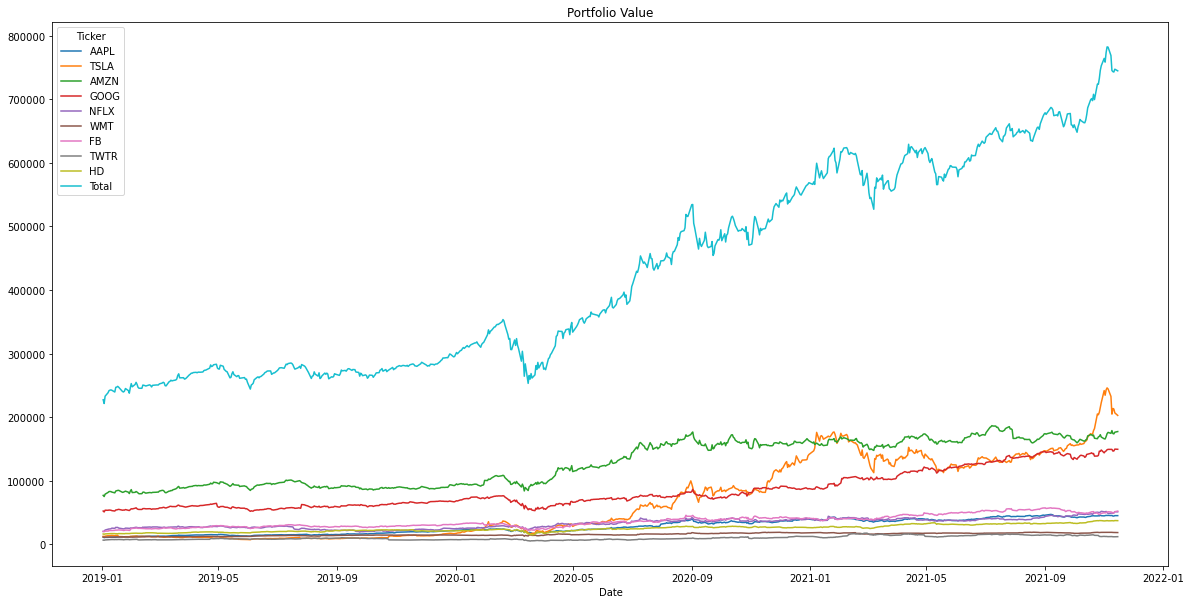

In [115]:
df_portfolio_value.plot(figsize=(20,10), title='Portfolio Value')

## Display of Various Charts, Tables, Calculations

In [116]:
fig_current_pnlvalue = px.pie(merged_portfolio_sp_YTD, 
                           values='Stock Gain / (Loss)', names='Ticker', 
                           title='<b>Portfolio Current P&L</b>',height=400, width=800
                          )
fig_current_value = px.pie(merged_portfolio_sp_YTD, 
                           values='Current Value', names='Ticker', 
                           title='<b>Portfolio Current Value</b>',height=400, width=800
                          )

# YTD Charts

In [117]:
# Ploty is an outstanding resource for interactive charts.

trace1 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Share YTD'][0:10],
    name = 'Ticker YTD')

trace2 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['SPY YTD'][0:10],
    name = 'SPY YTD')
    
data1 = [trace1, trace2]

layout1 = go.Layout(title = '<b>YTD Return vs SPY YTD</b>'
    , barmode = 'group'
    , yaxis=dict(title='Returns', tickformat=".2%")
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.8,y=1)
    ,height=800, width=1600
    )

fig1 = go.Figure(data=data1, layout=layout1)

# Total Return Comparison Charts

In [118]:
trace3 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Ticker Return'][0:10],
    name = 'Ticker Total Return')

trace4 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['SP Return'][0:10],
    name = 'SP500 Total Return')
    
data2 = [trace3, trace4]

layout2 = go.Layout(title = '<b>Total Return vs S&P 500</b>'
    , barmode = 'group'
    , yaxis=dict(title='Returns', tickformat=".2%")
    , xaxis=dict(title='Ticker', tickformat=".2%")
    , legend=dict(x=.8,y=1)
    ,height=800, width=1600
    )

fig2 = go.Figure(data=data2, layout=layout2)

## Gain / (Loss) Total Return vs SPY

# 

In [119]:
trace5 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Stock Gain / (Loss)'][0:10],
    name = 'Ticker Total Return ($)')

trace6 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['SPY Gain / (Loss)'][0:10],
    name = 'SPY Total Return ($)')

trace7 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Ticker Return'][0:10],
    name = 'Ticker Total Return %',
    yaxis='y2')

data3 = [trace5, trace6, trace7]

layout3 = go.Layout(title = '<b>Gain / (Loss) Total Return vs SPY</b>'
    , barmode = 'group'
    , yaxis=dict(title='Gain / (Loss) ($)')
    , yaxis2=dict(title='Ticker Return', overlaying='y', side='right', tickformat=".2%")
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.75,y=1)
    ,height=800, width=1600
    )

fig3 = go.Figure(data=data3, layout=layout3)

### Total Cumulative Investments Over time

In [120]:
trace8 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum Invst'],
    # mode = 'lines+markers',
    name = 'Cum Invst')

trace9 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum SP Returns'],
    # mode = 'lines+markers',
    name = 'Cum SP500 Returns')

trace10 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum Ticker Returns'],
    # mode = 'lines+markers',
    name = 'Cum Ticker Returns')

trace11 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum Ticker ROI Mult'],
    # mode = 'lines+markers',
    name = 'Cum ROI Mult'
    , yaxis='y2')


data4 = [trace8, trace9, trace10, trace11]

layout4 = go.Layout(title = '<b>Total Cumulative Investments Over Time</b>'
    , barmode = 'group'
    , yaxis=dict(title='Returns')
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.4,y=1)
    , yaxis2=dict(title='Cum ROI Mult', overlaying='y', side='right')  
    ,height=800, width=1600
    )

fig4 = go.Figure(data=data4, layout=layout4)

### Method to have per symbol selection for charts

In [121]:
def multi_plot(df, chartTitle, label, addAll = True):
   
    
    fig = go.Figure(layout=go.Layout(height=800, width=1600))
    
    
    for column in df.columns.to_list():
        if column != 'Total':
            fig.add_trace(
                go.Scatter(
                    x = df.index,
                    y = df[column],
                    name = column
                 )
            )
        elif column == 'Total':
            fig.add_trace(
            go.Scatter(
                x = df.index,
                y = df[column],
                name = column,
                visible='legendonly'

                ) 
            )
    
    
    button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df.columns.isin(df.columns),
                               'title': 'All',
                               'showlegend':True}])

    def create_layout_button(column):
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': df.columns.isin([column]),
                             'title': column,
                             'showlegend': True}])

    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 1,
            buttons = ([button_all] * addAll) + 
                list(df.columns.map(lambda column: create_layout_button(column)))
            
            )
            
            
        ],title_text=chartTitle)
    return fig


### Charts for Daily Returns, Cumulative Returns, Rolling 21 Day Returns, Rolling 60 Day Beta for the Portfolio and Simulated Returns

In [122]:
fig5 = multi_plot(df_daily_returns,'<b>Daily Returns</b>',"Daily Returns")

In [123]:
fig6 = px.box(cum_daily_returns_df, title = '<b>Cumulative  Returns</b>'
              ,height=800, width=1600
        )

In [124]:
fig7 = multi_plot(df_daily_returns_std_21, '<b>Rolling 21 Day Returns</b>',"21 Day Returns")

In [125]:
fig8= px.bar(df_sharpe,title='<b>Sharpe Ratio</b>',
                      labels={"value": "Sharpe Ratio"}
                      #,template='simple_white'
                      ,height=800, width=1600
                     )

In [126]:
fig9 = px.line(rolling_portfolio_beta,title='<b>Rolling 60 Day Beta of the Portfolio</b>',
                      labels={"value": "Beta"}
                      #,template='simple_white'
                      ,height=800, width=1600
                     )

In [127]:
fig_portfolio_value = multi_plot(df_portfolio_value,'<b>Portfolio Value<b>', 'Portfolio Value')

In [128]:
fig_simulated_returns = px.line(df_simulated_data, 
                          title='<b>Simulated Returns of the Portfolio</b>',
                          labels={"value": "Returns"}
                          ,height=800, width=1600
                         )

In [129]:
fig_simulated_cum_pnl = px.line(cumulative_pnl, 
                          title='<b>Simulated Cumulative P&L<b>',
                          labels={"value": "Returns"}
                          ,height=800, width=1600
                         )

## Display in Dash/Plotly
All charts and tables are displayed in plotly. Plotly creates a local web server to view the results

In [ ]:
app = dash.Dash()

app.layout = html.Div( children=[
    html.Div([
        html.H1(children='Portfolio Analysis Dashboard',style={
                'textAlign': 'center','align': 'center'})
    ])
    ,html.Hr()
    ,html.Div(
            dash_table.DataTable(
                id="Portfolio Summary Table",
                columns=[
                    {"name": "Ticker", "id": "Ticker"},
                    {
                        "name": "Cost Basis",
                        "id": "Cost Basis",
                        "type": "numeric",
                        "format": Format()  # formatted using the Format() object
                        .scheme(Scheme.fixed)
                        .precision(2)
                        .symbol_prefix("$")
                        .symbol(Symbol.yes)
                        .group(Group.yes),
                    },
                   {
                        "name": "Current Value",
                        "id": "Current Value",
                        "type": "numeric",
                        # formatted using FormatTemplate:
                        "format": FormatTemplate.money(2),
                    },
                    {
                        "name": "Stock Gain / (Loss)",
                        "id": "Stock Gain / (Loss)",
                        "type": "numeric",
                        # formatted using FormatTemplate:
                        "format": FormatTemplate.money(2),
                    },
                    {
                        "name": "% Change",
                        "id": "Pct Change",
                        "type": "numeric",
                        # formatted using FormatTemplate:
                        "format": FormatTemplate.percentage(2),
                    },
                ]
                ,data=df.to_dict("records")
                ,fixed_rows={'headers': True}
                ,style_table={'maxHeight': '50ex','overflowY': 'scroll','width': '100%','minWidth': '100%',} 
                ,style_cell={'minWidth': 80, 'maxWidth': 250, 'width': 250,
                             'font_family': 'sans-serif','font_size': '20px','text_align': 'center'}
                ,style_data={'whiteSpace': 'normal','height': 'auto'}
                ,fill_width=False
                
            )
        )
     
    ,html.Div([
        html.Div([ 
                    dcc.Graph(id="Portfolio Summary", figure=fig_current_value)], 
                style={'width': '48%', 'display': 'inline-block'})

        ,html.Div([
                    dcc.Graph(id="Portfolio PNL Summary", figure=fig_current_pnlvalue)],
                style={'width': '48%', 'align': 'right', 'display': 'inline-block'})
    ])
    #,dcc.Graph(id="Portfolio Summary", figure=fig_current_value)
    #,dcc.Graph(id="Portfolio PNL Summary", figure=fig_current_pnlvalue)
    ,html.Div([ dcc.Graph(id="Portfolio Value", figure=fig_portfolio_value)])
    
    ,html.Div([ dcc.Graph(id="Daily Returns", figure=fig5)])
    
    
    ,html.Div([dcc.Graph(id="Cumulative Returns", figure=fig6)])
    
   
    ,html.Div([dcc.Graph(id="Rolling 21 Day Returns", figure=fig7)])
    ,dcc.Graph(id="Sharpe Ratio", figure=fig8)
    

    ,html.Div([dcc.Graph(id="Rolling 60 Day Beta", figure=fig9)])
    ,html.H3(children=f"Average 60 Day Rolling Portfolio Beta is {avg_rolling_portfolio_beta:.2f}"
             )
    
    ,html.Div([dcc.Graph(id="Simulated Returns", figure=fig_simulated_returns)])
    
    ,html.Div([dcc.Graph(id="Simulated Cumulative P&L", figure=fig_simulated_cum_pnl)])
    ,html.H3(children=
        f"Summary: "
        f"There is a 95% chance that a current investment of ${initial_investment:,.2f} in the portfolio"
        f" over the next three years will end within in the range of"
        f" ${ci_lower:,.2f} and ${ci_upper:,.2f}."
    )
    
    ,html.Div([dcc.Graph(id="YTD Summary", figure=fig1)])
    ,html.Div([dcc.Graph(id="Total Return", figure=fig2)])
    

    ,html.Div([dcc.Graph(id="Total Cumulative Return", figure=fig3)])
    ,html.Div([dcc.Graph(id="Total Cumulative ROI", figure=fig4)])
    
    #,dcc.Graph(id="YOY Summary", figure=fig_year_summary)
    ##,dcc.Graph(id="Daily Volume", figure=fig_vol)
    #,dcc.Graph(id="Daily Returns", figure=fig_returns)
    #,dcc.Graph(id="Cumulative Daily Returns", figure=fig_cum_returns)
    #,dcc.Graph(id="Cumulative BTC Daily Returns", figure=fig_cum_btc_returns)
    #,dcc.Graph(id="Rolling 21 Day Daily Returns", figure=fig_daily_returns_std_21)
    #,dcc.Graph(id="Sharpe Ratio", figure=fig_sharpe_ratio)
    
    ##,dcc.Graph(id="Daily Returns and Volume", figure=fig)
])

app.css.append_css({
    'external_url': 'https://codepen.io/chriddyp/pen/bWLwgP.css'
})



#rendered = render_template('pdf_template.html')
#pdf = pdfkit.from_string(rendered, False)
#response = make_response(pdf)
#response.headers['Content-Type'] = 'application/pdf'
#response.headers['Content-Disposition'] = 'attachment; filename=output.pdf'


if __name__ == "__main__":
    #app.run_server(debug=True)
    app.run_server( port = 8096, dev_tools_ui=True, #debug=True,
              dev_tools_hot_reload =True, threaded=True)




Dash is running on http://127.0.0.1:8096/

Dash is running on http://127.0.0.1:8096/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8096/ (Press CTRL+C to quit)
